In [2]:
#import pandas
import pandas as pd

# To ignore warnings, use the following code to make the display more attractive.
# Import seaborn and matplotlib.
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", color_codes=True)
customer_churn_df = pd.read_excel('/Users/Owner/Downloads/CTBA_M3_Customer_Churn_only.xlsx')

In [3]:
# Calculate churn statistics
churn_stats = customer_churn_df['churn (Yes = 1)'].value_counts().reset_index()
churn_stats.columns = ['Churn', 'Count']

# Calculate percentages
churn_stats['Percentage'] = (churn_stats['Count'] / churn_stats['Count'].sum()) * 100


churn_stats.head(3)


,Churn,Count,Percentage
0,0,904,60.266667
1,1,596,39.733333


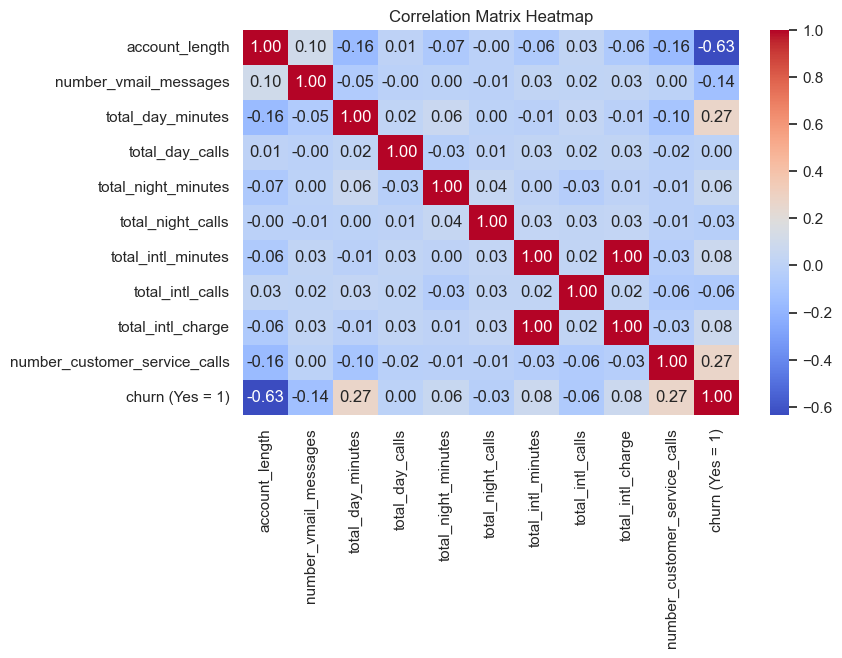

In [15]:
# Calculate correlation matrix -- trying to see which variables may impact churn
correlation_matrix = customer_churn_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 5))

# Create a heatmap to visualize the selected correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Set the title of the heatmap
plt.title("Correlation Matrix Heatmap")

# Show the heatmap
plt.show()




In [16]:
# Extract the correlation with the churn column
churn_correlation = correlation_matrix['churn (Yes = 1)'].sort_values(ascending=False)

churn_correlation

churn (Yes = 1)                  1.000000
total_day_minutes                0.267090
number_customer_service_calls    0.266815
total_intl_charge                0.075570
total_intl_minutes               0.075543
total_night_minutes              0.055900
total_day_calls                  0.000950
total_night_calls               -0.025625
total_intl_calls                -0.062784
number_vmail_messages           -0.135737
account_length                  -0.634954
Name: churn (Yes = 1), dtype: float64

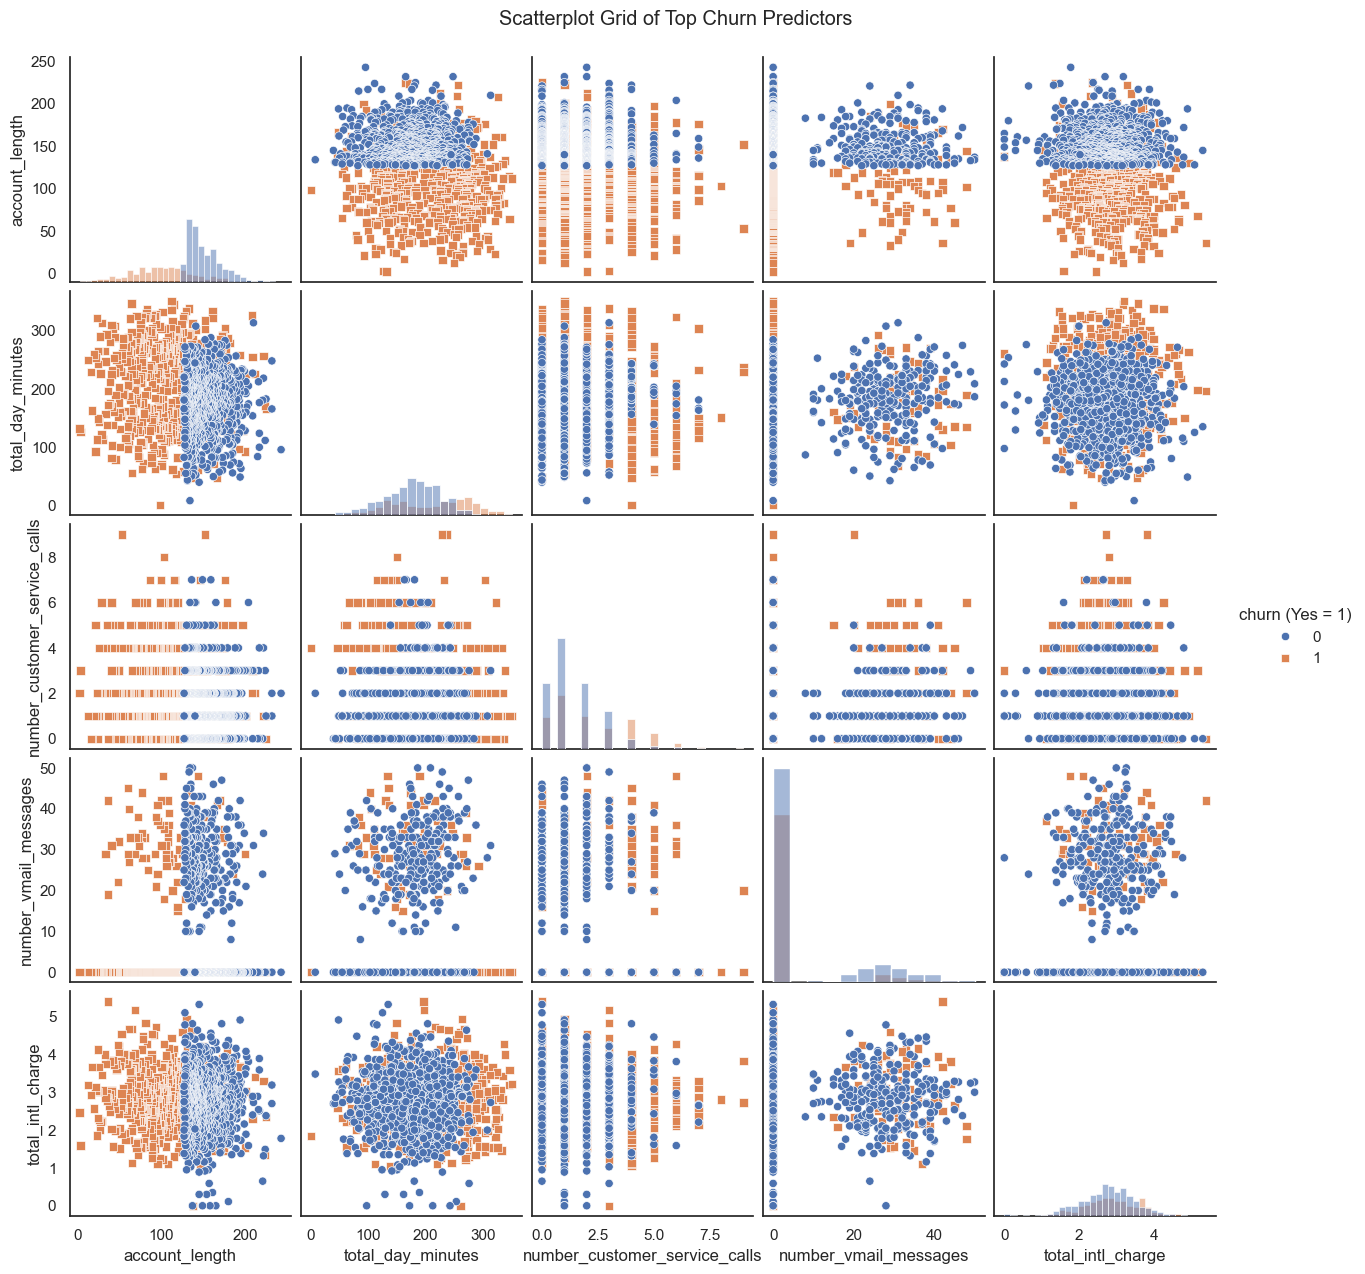

In [17]:

# Select the top predictors and the churn column
top_predictors = ['account_length', 'total_day_minutes', 'number_customer_service_calls', 'number_vmail_messages', 'total_intl_charge', 'churn (Yes = 1)']
predictors_df = customer_churn_df[top_predictors]

# Create a scatterplot grid
sns.pairplot(predictors_df, hue='churn (Yes = 1)', diag_kind='hist', markers=["o", "s"])

# Display the plot
plt.suptitle('Scatterplot Grid of Top Churn Predictors', y=1.02)
plt.show()


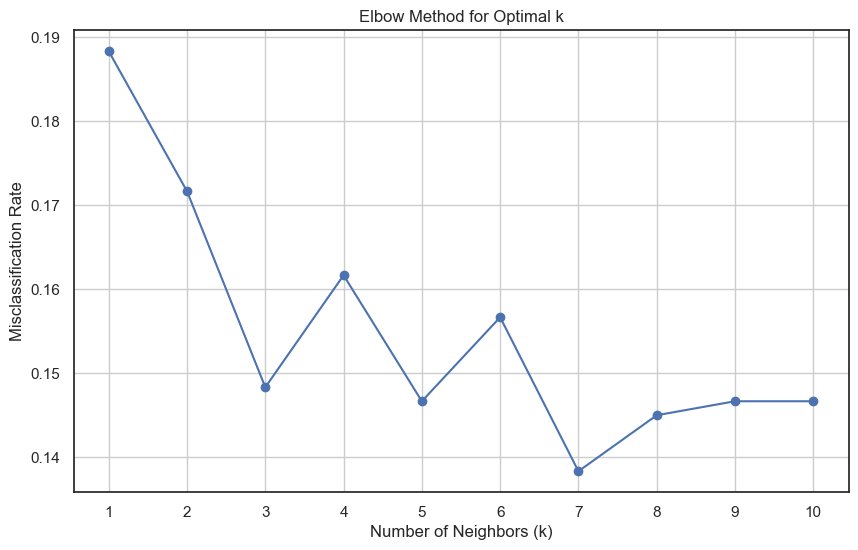

(7, 0.1383333333333333)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define features and target variable
X = customer_churn_df.drop(columns=['churn (Yes = 1)'])
y = customer_churn_df['churn (Yes = 1)']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets (60% training, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Evaluate k-NN for k values from 1 to 10 using the elbow method
misclassification_rates = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    misclassification_rate = 1 - accuracy_score(y_test, y_pred)
    misclassification_rates.append(misclassification_rate)

# Plot the elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), misclassification_rates, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Misclassification Rate')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Best k based on the elbow method
best_k = np.argmin(misclassification_rates) + 1
best_k, misclassification_rates[best_k - 1]


In [19]:
# Build and evaluate the final k-NN model with k=7
knn_best = KNeighborsClassifier(n_neighbors=7)
knn_best.fit(X_train, y_train)

# Predict on the test set
y_test_pred = knn_best.predict(X_test)

# Calculate the misclassification rate
misclassification_rate_best_k = 1 - accuracy_score(y_test, y_test_pred)

misclassification_rate_best_k


0.1383333333333333

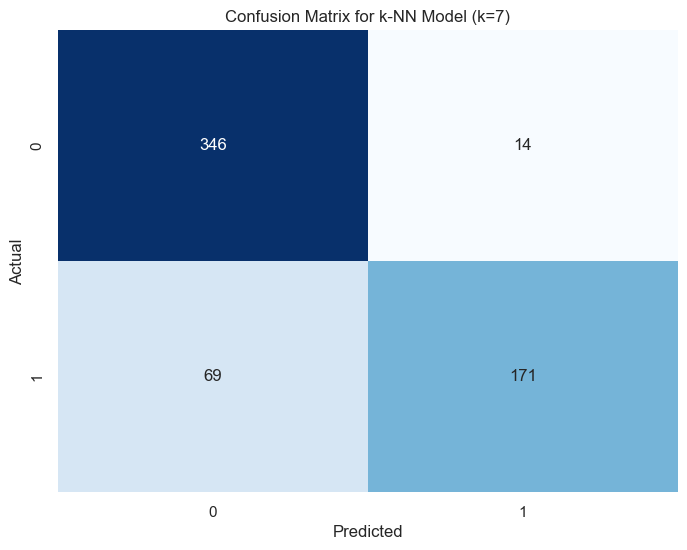

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for k-NN Model (k=7)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


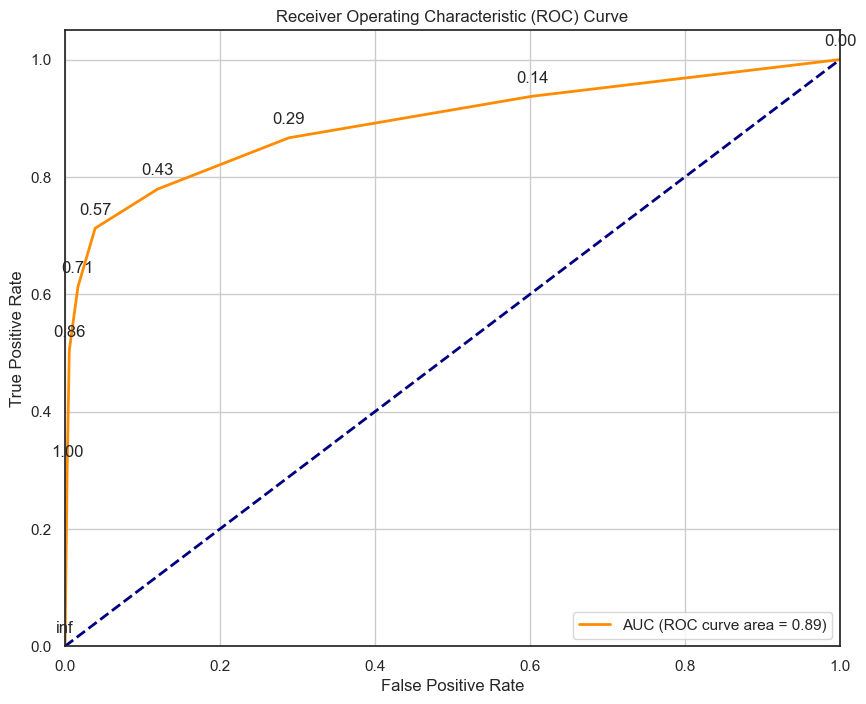

In [22]:
from sklearn.metrics import roc_curve, auc

# Get the probability scores for the positive class
y_test_prob = knn_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC (ROC curve area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Indicate threshold values on the curve
for i, thr in enumerate(thresholds):
    plt.annotate(f'{thr:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
